In [18]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import datetime
import warnings

warnings.filterwarnings("ignore")
%xmode verbose
sns.set()
np.random.seed(4)

Exception reporting mode: Verbose


# Importing datasets

In [19]:
# Mythri Nagar data => 5th May to 15th May (11 days) > Train on `08` days > Test on `03` days
# Labbipet_New data => 5th May to 18th May (14 days) > Train on `10` days > Test on `04` days
!ls

Complete.ipynb
Labbipet_New.xls
Missing data.ipynb
Mythri Nagar.xls
sanger-machine-learning-workshop


In [22]:
def interpolate_data(fname, sheetname, timestamp):
    df = pd.read_excel(fname, sheet_name=sheetname, parse_dates=[["Date", "Time"]])
    df.drop(["SLNo", "Input Name"], inplace=True, axis=1)
    df.set_index("Date_Time", inplace=True)

    date_time_idx = pd.date_range(start=timestamp + " 00:00:00", end=timestamp + " 23:59:00", periods=24*60)
    df_full = pd.DataFrame(data={"Depth":np.full(24*60, fill_value=np.nan)}, index=date_time_idx)
    
    for i in range(len(df_full)):
        if i == len(df_full)-1:
            df_full["Depth"][i] = df.loc[df_full.index[i]:].values.mean()   
        else:
            df_full["Depth"][i] = df.loc[df_full.index[i]:df_full.index[i+1]].values.mean()   
   

    series = pd.Series(df_full.values.ravel(), index = df_full.index)
    series.interpolate(method='time', limit_direction='both', inplace=True)
    
    fig = plt.figure(figsize=(12,10))
    gs = matplotlib.gridspec.GridSpec(nrows=2, ncols=2, hspace=0.3, wspace=0.3, figure=fig)
    
    ax1 = fig.add_subplot(gs[0,0])
    sns.lineplot(data=df, ax=ax1)
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Depth")
    ax1.set_title("Unevenly spaced Data")
    plt.xticks(rotation=45)
    
    ax2 = fig.add_subplot(gs[0,1])
    plt.plot(df_full)
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Depth")
    ax2.set_title("Evenly spaced Data")
    plt.xticks(rotation=45)

    ax3 = fig.add_subplot(gs[1,:])
    sns.lineplot(data=series, ax=ax3)
    ax3.set_xlabel("Time")
    ax3.set_ylabel("Depth")
    ax3.set_title("Interpolated Data")
    plt.xticks(rotation=45)
    
    plt.show()
    return series

In [15]:
def load_data(fname, sheetnames, timestamps):
    data = pd.Series()
    for sn, ts in zip(sheetnames, timestamps):
        data = data.append(interpolate_data(fname, sn, ts))
        
    return data

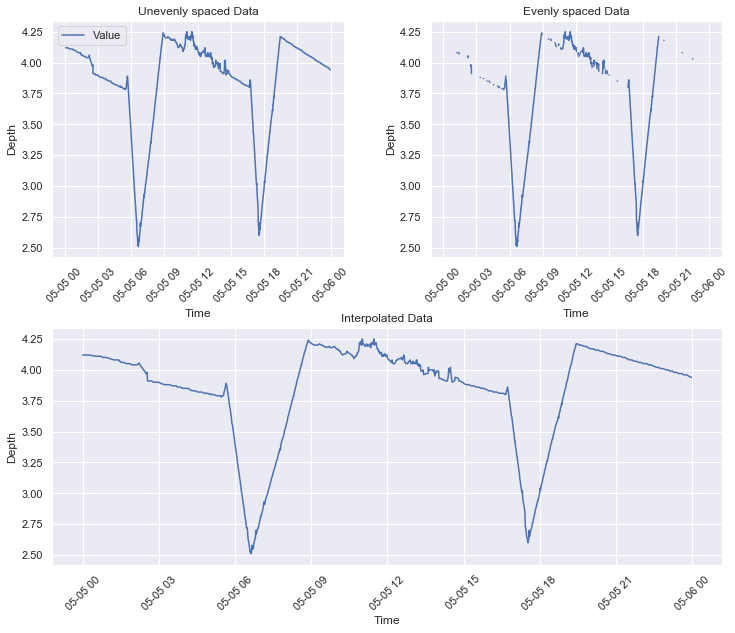

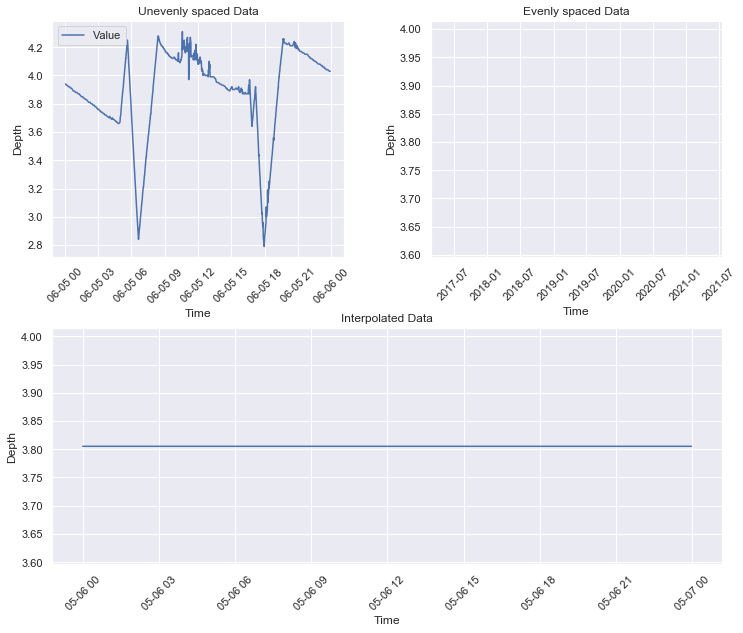

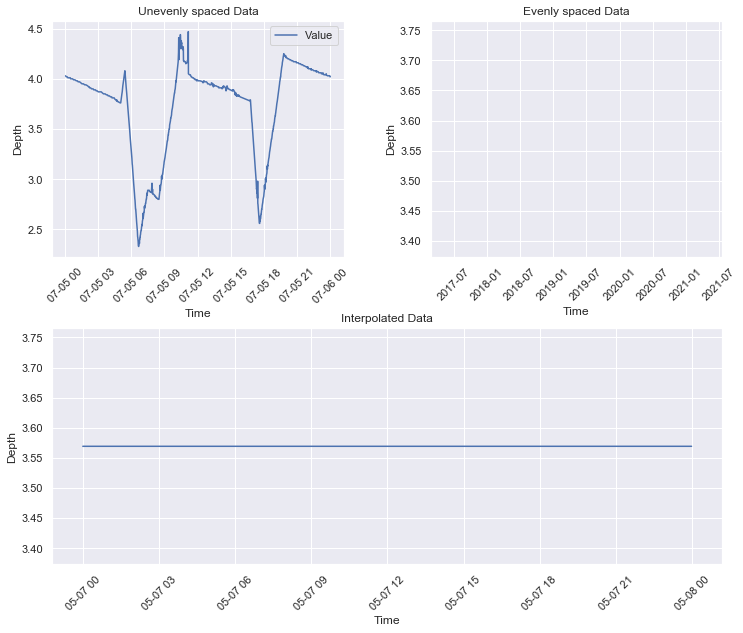

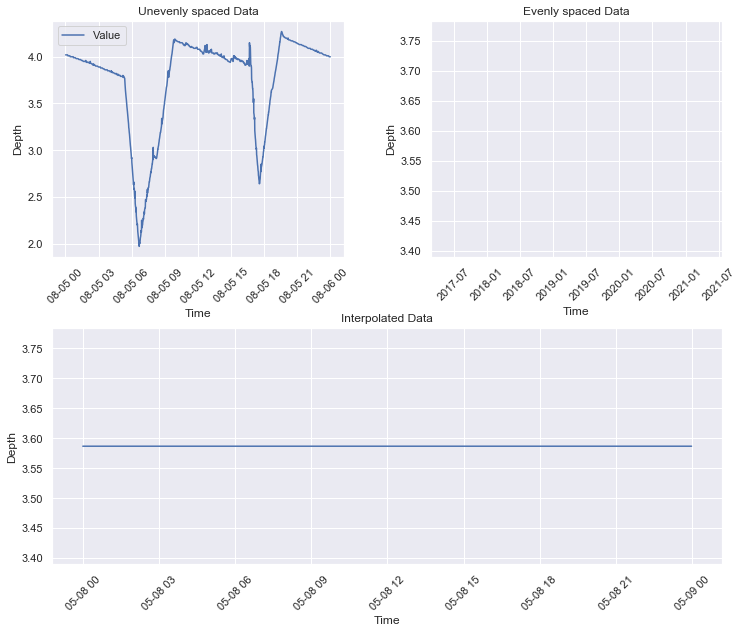

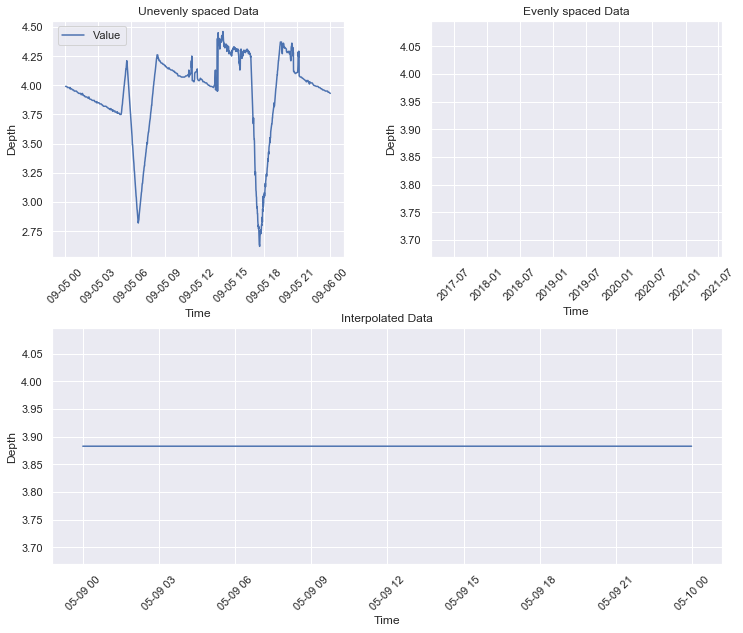

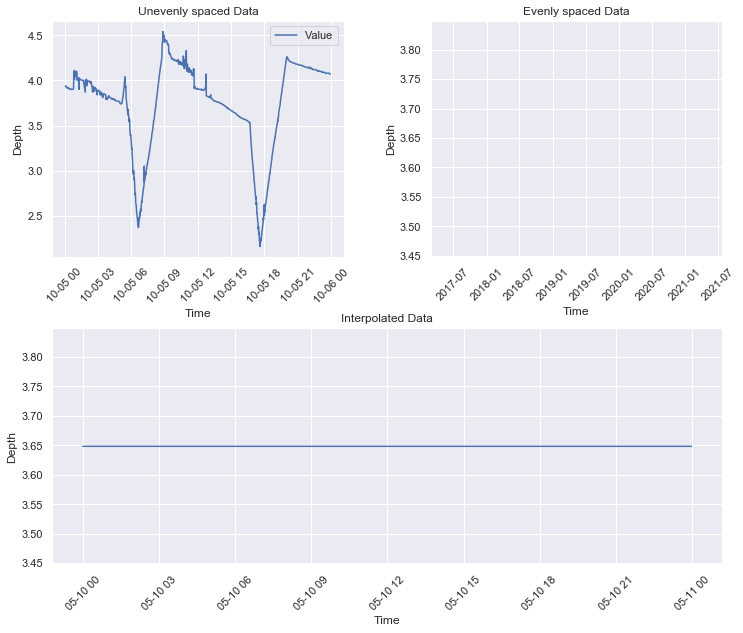

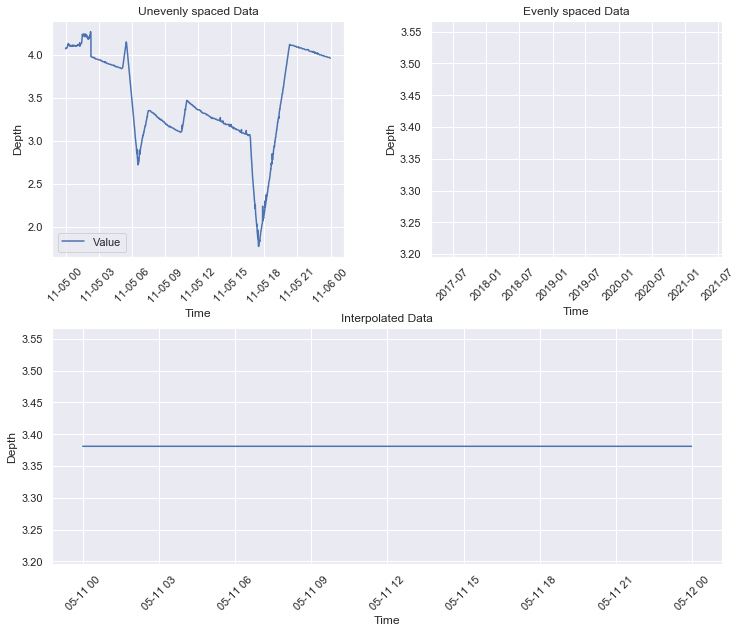

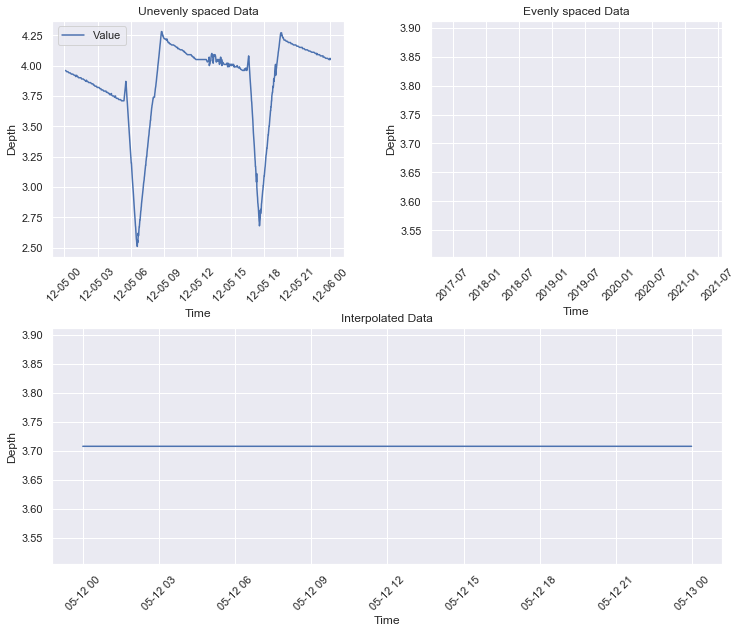

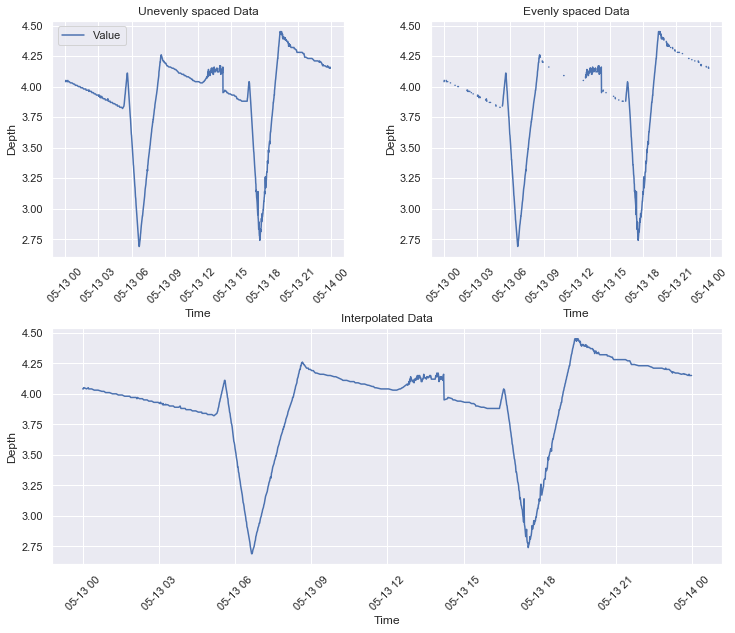

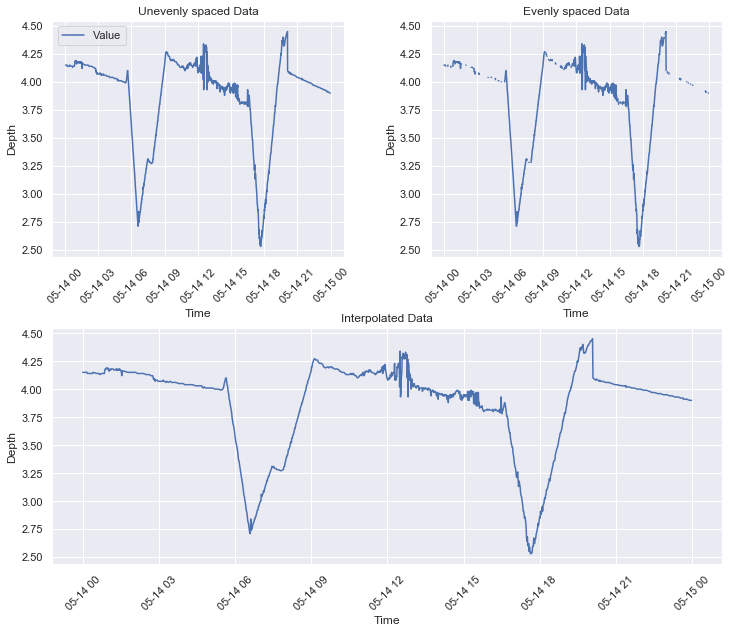

In [16]:
sheetnames = ["5-May", "6-May", "7-May", "8-May", "9-May", "10-May", "11-May", "12-May", "13-May", "14-May"]
timestamps = ["2019-05-05", "2019-05-06", "2019-05-07", "2019-05-08", "2019-05-09", "2019-05-10", "2019-05-11", "2019-05-12",
             "2019-05-13", "2019-05-14"]
fname = "Labbipet_New.xls"
train_data = load_data(fname, sheetnames, timestamps)

# Anomaly detection

In [229]:
def make_chunks(data, segment_len=32, sliding_len=2):
    segments= []

    for start_pos in range(0, len(data), sliding_len):
        end_pos = start_pos + segment_len

        segment = np.copy(data[start_pos:end_pos])

        if not len(segment) == segment_len:
            continue

        segments.append(segment)

    segments = np.array(segments) 
    return segments

In [248]:
def plot_waves(waves, step=2):
    plt.figure()
    n_graph_rows = 3
    n_graph_cols = 3
    graph_n = 1
    wave_n = 0
    for _ in range(n_graph_rows):
        for _ in range(n_graph_cols):
            axes = plt.subplot(n_graph_rows, n_graph_cols, graph_n)
            plt.plot(waves[wave_n])
            graph_n += 1
            wave_n += step
    plt.tight_layout()
    plt.show()

In [307]:
def windowing_func(segment_len, plot=False):
    vals = np.linspace(0, np.pi, segment_len)
    window_func = np.sin(vals)*10
    if plot:
        plt.plot(window_func)
        plt.show()
    return window_func

def normalize_waves(segments, window_func):
    windowed_segments = []
    for segment in segments:
        windowed_segments.append(np.copy(segment) * window_func)
    windowed_segments = np.array(windowed_segments)
    return windowed_segments

In [308]:
def reconstruct(data, window_func, clusterer):
    window_len = len(window_func)
    slide_len = window_len//2
    segments = sliding_chunker(data, window_len, slide_len)
    reconstructed_data = np.zeros(len(data))
    for segment_n, segment in enumerate(segments):
        segment *= window_func
        nearest_match_idx = clusterer.predict(np.expand_dims(segment, axis=0))[0]
        nearest_match = np.copy(clusterer.cluster_centers_[nearest_match_idx])

        pos = segment_n * slide_len
        reconstructed_data[pos:pos+window_len] += nearest_match

    return np.array(reconstructed_data)

In [309]:
def reconstruction_error(test_data, window_func, kmeans):
    recons = reconstruct(test_data, window_func, kmeans)

    error = recons - anomalous_data

    max_err = error.max()
    error_98 = np.percentile(error, 98)
    print("Maximum error:", max_err)
    print("98% of error:", error_98)

    plt.figure(figsize=(12,8))
    plt.plot(test_data, "-", label="Original data", alpha=0.5)
    plt.plot(recons, "--", label="Reconstructed data", alpha=0.5)
    plt.plot(error, label="Reconstruction Error", alpha=1)
    plt.plot(list(range(len(recons))), np.ones_like(recons)*error.max(), alpha=0.8)
    plt.plot(list(range(len(recons))), np.ones_like(recons)*error.min(), alpha=0.8)
    plt.legend()
    plt.show()

In [310]:
data.values.shape

(1440,)

In [317]:
# scaler = MinMaxScaler(feature_range=(0, 100))
scaler = StandardScaler()
data = scaler.fit_transform(data.values.reshape(-1,1))
data = data.reshape(-1)

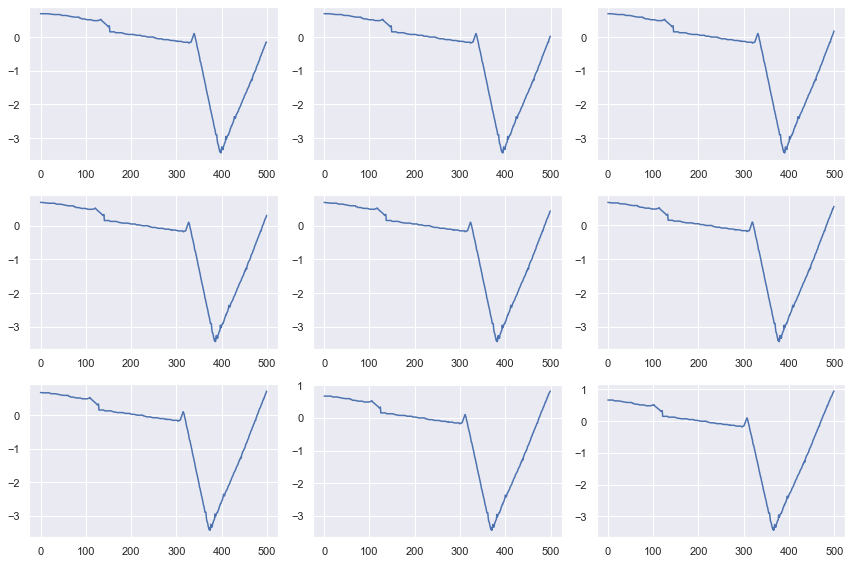

---------------------------------------------------------------------------------------------------------------


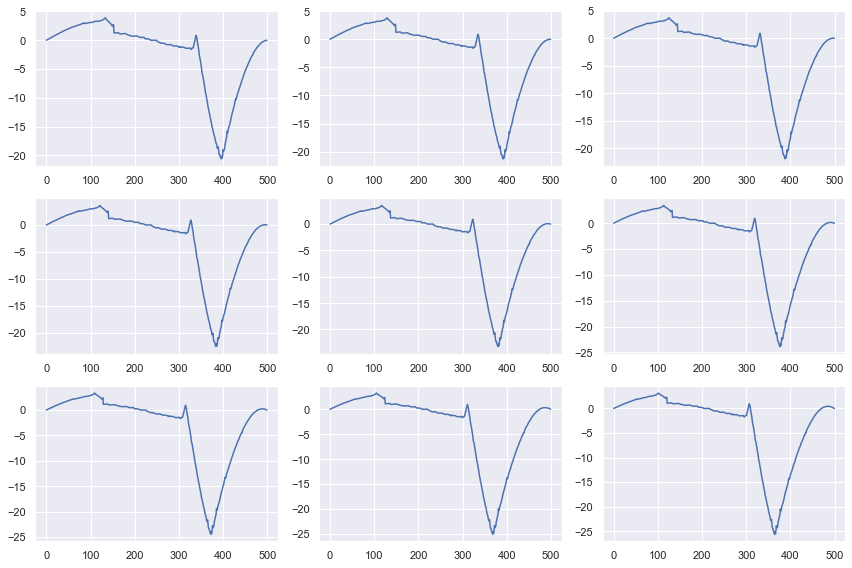

In [319]:
seg_len=500

segments = make_chunks(data, segment_len=seg_len)
plot_waves(segments)
print("---------------------------------------------------------------------------------------------------------------")
window_fn = windowing_func(segment_len=seg_len)
normal_segments = normalize_waves(segments, window_fn)
plot_waves(normal_segments)